In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import itertools
from collections import deque
from collections import Counter
import os
import csv
import pickle
import math
import re
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

from sklearn.svm import SVC
from xgboost import XGBClassifier

import sklearn.metrics as met
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

In [2]:
raw_path = "/home/kavin/Silo/Research/WASH/Datasets/uci-smartphone-based-recognition-of-human-activities/original/raw_data_merged/"
labels = np.loadtxt("/home/kavin/Silo/Research/WASH/Datasets/uci-smartphone-based-recognition-of-human-activities/original/RawData/labels.txt")

In [3]:
raw_data = np.loadtxt("/home/kavin/Silo/Research/WASH/Datasets/uci-smartphone-based-recognition-of-human-activities/original/raw_data_merged/sensor_data_cpd_labels_04.txt")

01


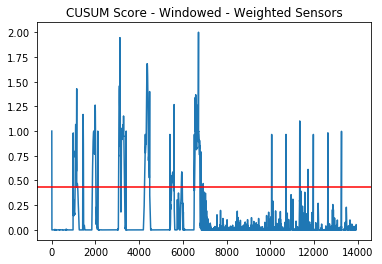

02


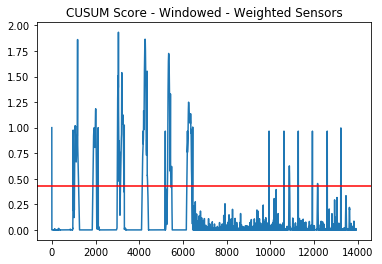

03


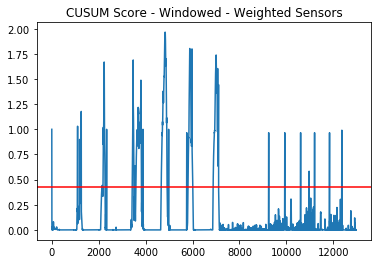

04


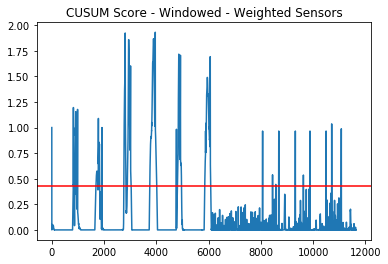

05


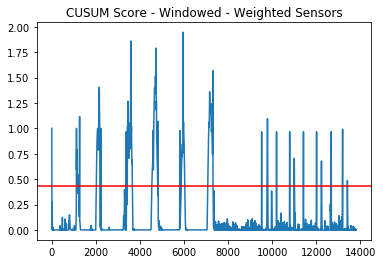

06


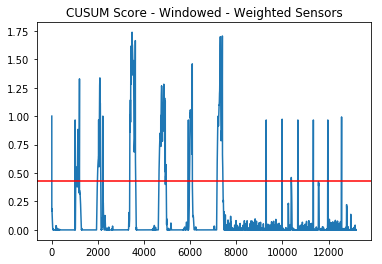

07
08


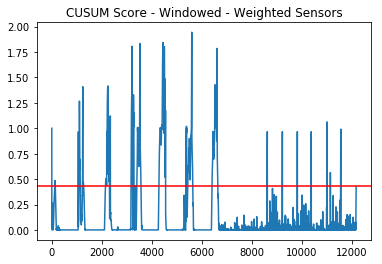

09


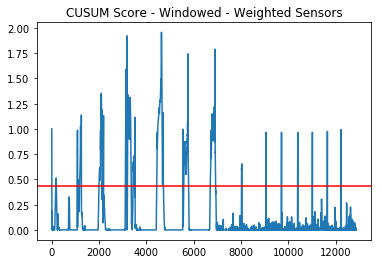

10


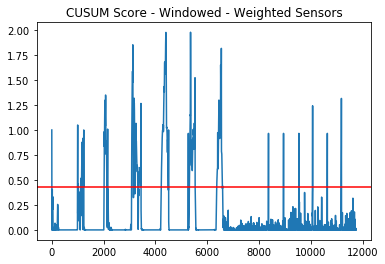

11


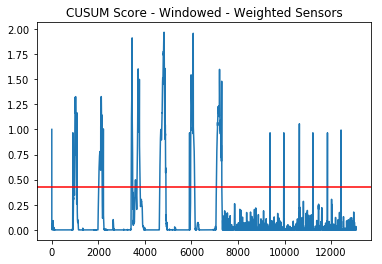

12


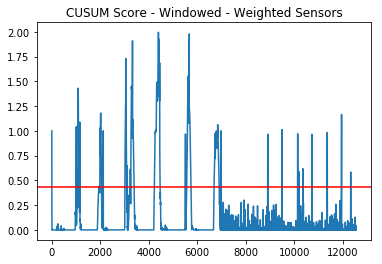

13
14


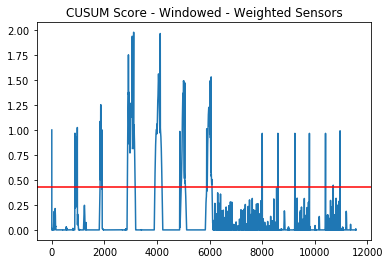

15


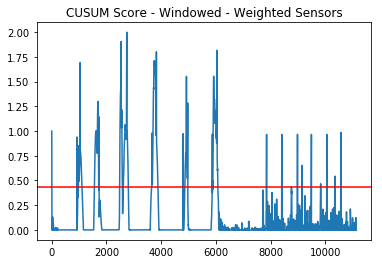

16
17


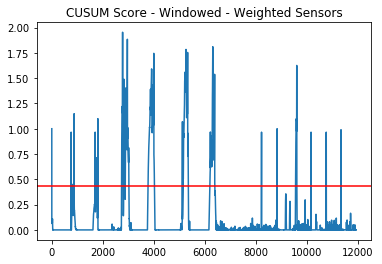

18


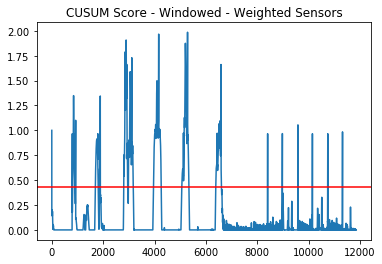

19
20


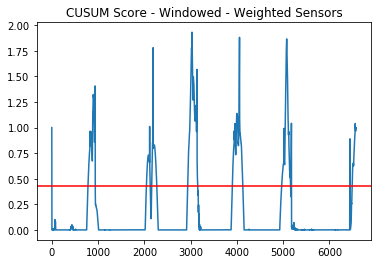

21


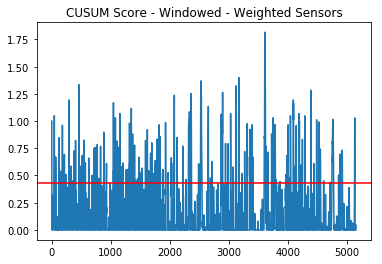

22


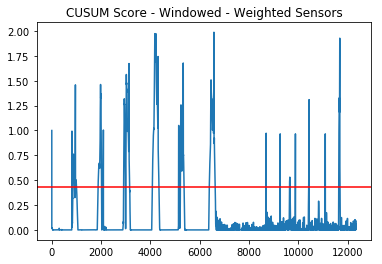

23
24


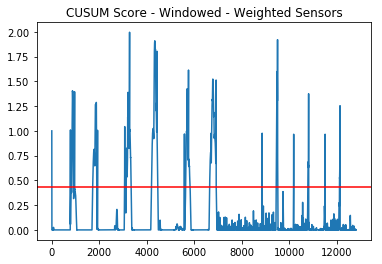

25


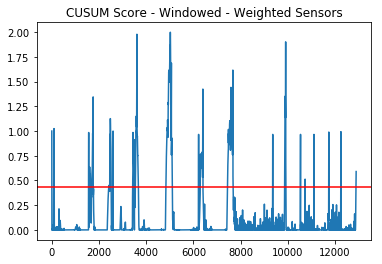

26
27


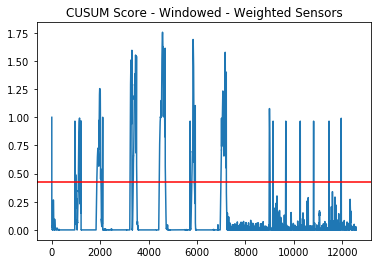

28
29
30


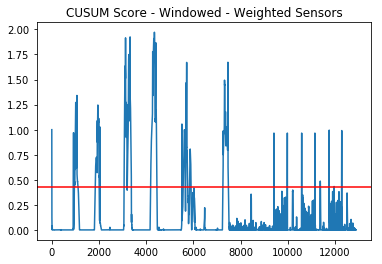

31


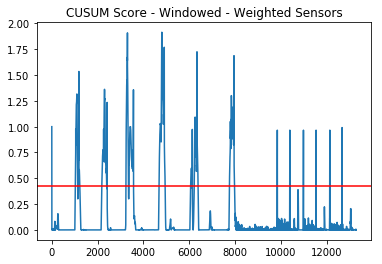

32


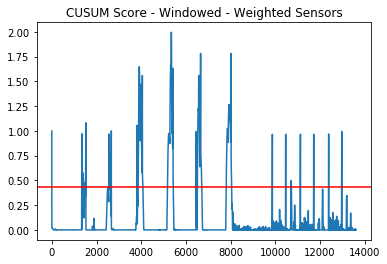

33


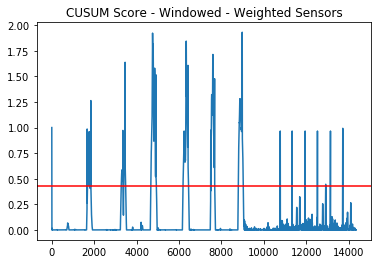

34


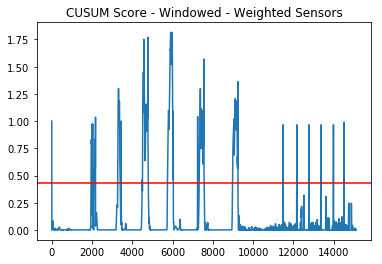

35


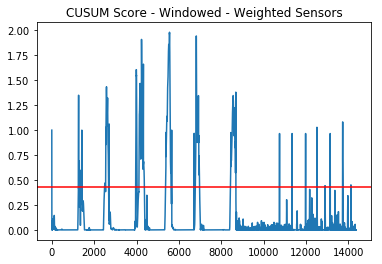

36
37


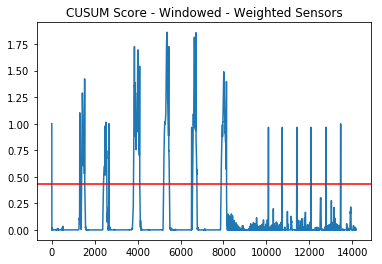

38


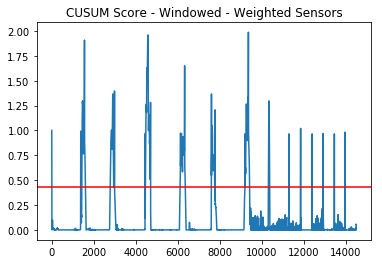

39


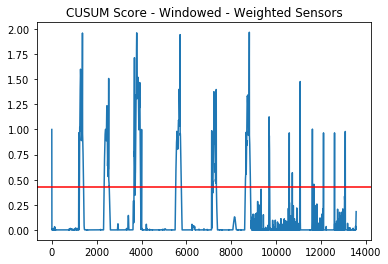

40


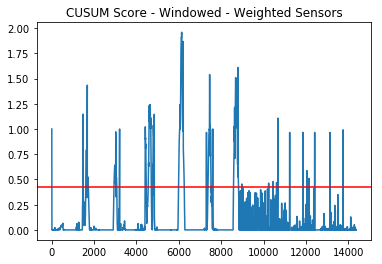

41


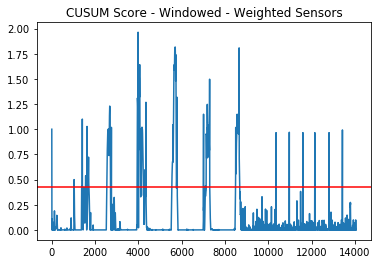

42


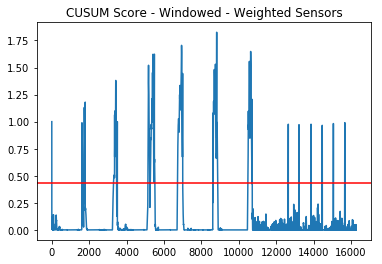

43
44


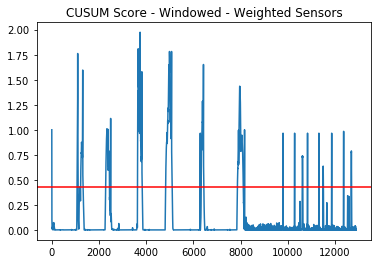

45
46


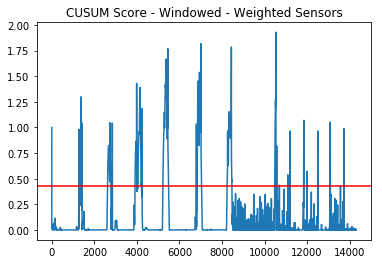

47


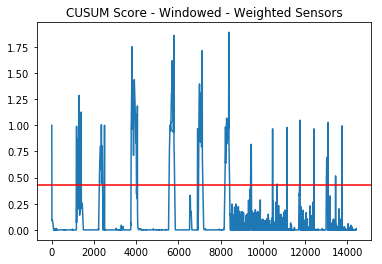

48
49


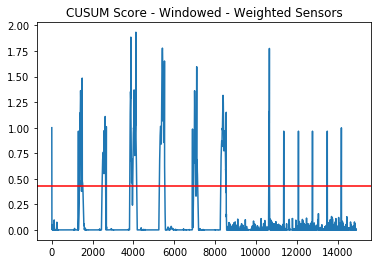

50


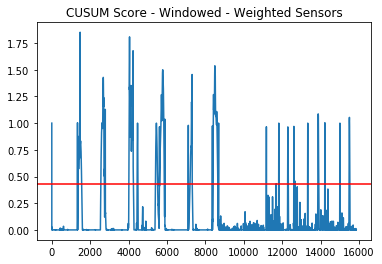

51
52


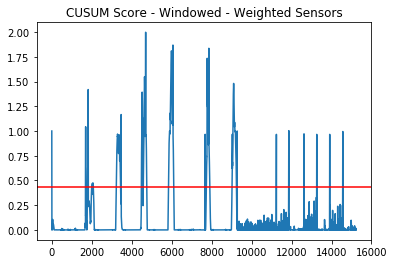

53


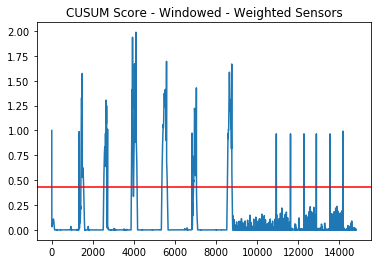

54


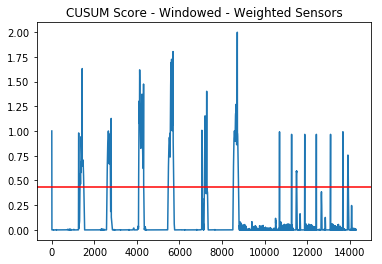

55
56


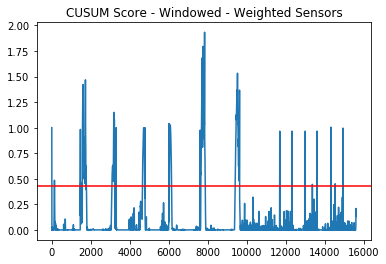

57
58


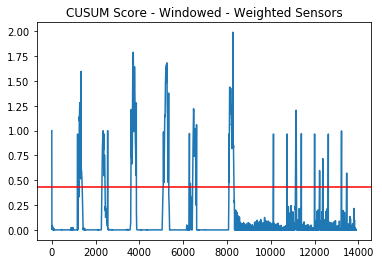

59
60
61


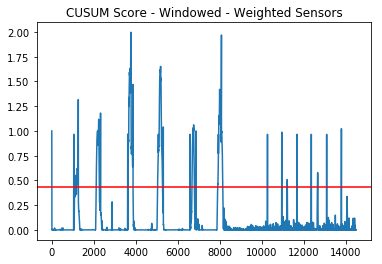

In [9]:
tprs, fprs, gmeans, mccs, delays = [],[],[],[],[]
for uuid in range(1, 62):
    uuid = str(int(uuid)).zfill(2)
    print(uuid)
    try:
        raw_data = np.loadtxt("{}sensor_data_cpd_labels_{}.txt".format(raw_path, uuid))
    except:
        continue
    sampling_rate, window_size = 50, 15
    window_size = int(sampling_rate * window_size)
    preds = []
    cusum_acc_x = []
    for idx in range(len(raw_data)):
        s = None
        start_idx = max(0, idx - window_size)
        window = raw_data[start_idx:idx+1, :-1]
        avg = 0.
        std = 0.
        avg = np.mean(window, axis=0)
        std = np.std(window, axis=0)
        for val in window:
            if(s is None):
                s = val
                #avg = s
            else:
                s = s+val

            s_t = (s-avg-2*std)
            s_t = np.amax(np.vstack((np.zeros_like(s_t), s_t)), axis=0)
            s = s_t
        cusum_acc_x.append(s)
    cusum_acc_x = np.array(cusum_acc_x)
    #'''
    cusum_reverse = []
    raw_data_flipped = np.flip(raw_data)
    for idx in range(len(raw_data_flipped)):
        s = None
        start_idx = max(0, idx - window_size)
        window = raw_data_flipped[start_idx:idx+1, :-1]
        avg = 0.
        std = 0.
        avg = np.mean(window, axis=0)
        std = np.std(window, axis=0)
        for val in window:
            if(s is None):
                s = val
                #avg = s
            else:
                s = s+val

            s_t = (s-avg-2*std)
            s_t = np.amax(np.vstack((np.zeros_like(s_t), s_t)), axis=0)
            s = s_t
        cusum_reverse.append(s)
    cusum_reverse = np.flip(np.array(cusum_reverse))
    #'''
    min_c = np.min(cusum_acc_x, axis=0)
    max_c = np.max(cusum_acc_x, axis=0)

    normalized_cusum = []
    for c in cusum_acc_x:
        normalized_cusum.append((c-min_c)/(max_c-min_c))
    normalized_cusum = np.array(normalized_cusum)
    #'''
    min_c = np.min(cusum_reverse, axis=0)
    max_c = np.max(cusum_reverse, axis=0)

    normalized_cusum_reverse = []
    for c in cusum_reverse:
        normalized_cusum_reverse.append((c-min_c)/(max_c-min_c))
    normalized_cusum_reverse = np.array(normalized_cusum_reverse)
    #'''
    final_cusum = []
    for c in normalized_cusum:
        #print(c.shape)
        final_cusum.append(np.max(c, axis=0))
    #'''
    final_cusum_reverse = []
    for c in normalized_cusum_reverse:
        final_cusum_reverse.append(np.max(c, axis=0))
    #'''
    cusum_score = np.array(final_cusum)+np.array(final_cusum_reverse)
    #cusum_score = np.array(final_cusum)
    
    plt.figure()
    plt.title("CUSUM Score - Windowed - Weighted Sensors")
    plt.plot(cusum_score)
    plt.axhline(y=0.43, color='r', linestyle='-')
    plt.show()
    preds = np.where(np.array(cusum_score)>0.4, 1, 0)
    cpd_preds = np.where(preds==1)[0]
    cpd_indices = np.where(raw_data[:, -1]==1)
    time_result=[]
    for pred_ind in cpd_preds:
        buffer_secs = 2
        ind_range = int((buffer_secs *sampling_rate)/2)
        pos = np.where(np.logical_and(cpd_indices>=pred_ind-ind_range, cpd_indices<=pred_ind+ind_range))[1]
        #pos = cpd_indices[(cpd_indices>=pred_ind-ind_range) & (cpd_indices<=pred_ind+ind_range)]
        time_result.append(pos)
    tp, fp, tn, fn = 0.,0.,0.,0.
    #print(time_result)
    for t in time_result:
        if t.size:
            tp+=1
        else:
            fp+=1
    predicted = np.unique(np.hstack(time_result))
    fn = len(set(np.arange(len(cpd_indices[0])))- set(predicted))
    tn = len(raw_data) - (tp+fp+fn)
    try:
        tpr = tp/(tp+fn)
        #print(tpr)
    except:
        tpr = 0.
    tprs.append(tpr)
    try:
        fpr = fp/(fp+tn)
    except:
        fpr = 0.
    fprs.append(fpr)
    try:
        mcc = (tp*tn - fp*fn)/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    except:
        mcc = 0.
    mccs.append(mcc)
    try:
        g_mean = math.sqrt(tp/(tp+fn)*(tn/(fp+tn)))
    except:
        g_mean = 0.
    gmeans.append(g_mean)

    time_delay = 0
    n = 0
    for t in range(len(time_result)):
        if time_result[t].size:
            td = cpd_indices[0][time_result[t][0]] - cpd_preds[t]
            time_delay += td
            n += 1.
    try:
        time_delay /= n
    except:
        time_delay = 0
    delays.append(time_delay)


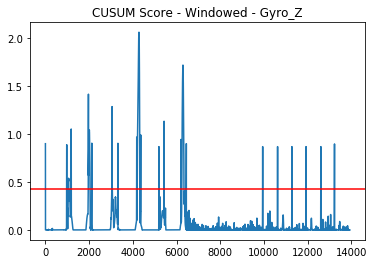

In [226]:
plt.figure()
plt.title("CUSUM Score - Windowed - Gyro_Z")
plt.plot(cusum_score)
plt.axhline(y=0.43, color='r', linestyle='-')
plt.show()

In [10]:
np.mean(tprs), np.mean(fprs), np.mean(gmeans), np.mean(mccs), np.mean(delays)

(1.0,
 0.0445237322403173,
 0.9774678543054087,
 0.747321305545452,
 2.639276593811054)

In [11]:
np.std(tprs), np.std(fprs), np.std(gmeans), np.std(mccs), np.std(delays)

(0.0,
 0.01112167567905912,
 0.005732500262787846,
 0.0644123918763372,
 2.1378246001068835)

In [72]:
tprs_5, fprs_5, gmeans_5, mccs_5, delays_5 = [],[],[],[],[]
for uuid in range(1, 62):
    uuid = str(int(uuid)).zfill(2)
    print(uuid)
    try:
        raw_data = np.loadtxt("{}sensor_data_cpd_labels_{}.txt".format(raw_path, uuid))
    except:
        continue
    samping_rate, window_size = 50, 5
    window_size = int(sampling_rate * window_size)
    preds = []
    cusum_acc_x = []
    for idx in range(len(raw_data)):
        s = None
        start_idx = max(0, idx - window_size)
        window = raw_data[start_idx:idx+1, :-1]
        avg = 0.
        std = 0.
        avg = np.mean(window, axis=0)
        std = np.std(window, axis=0)
        for val in window:
            if(s is None):
                s = val
                #avg = s
            else:
                s = s+val

            s_t = (s-avg-2*std)
            s_t = np.amax(np.vstack((np.zeros_like(s_t), s_t)), axis=0)
            s = s_t
        cusum_acc_x.append(s)
    cusum_acc_x = np.array(cusum_acc_x)
    preds = np.where(np.array(cusum_acc_x[:,5])>0.4, 1, 0)
    cpd_preds = np.where(preds==1)[0]
    cpd_indices = np.where(raw_data[:, -1]==1)
    time_result=[]
    for pred_ind in cpd_preds:
        buffer_secs = 2
        ind_range = int((buffer_secs *sampling_rate)/2)
        pos = np.where(np.logical_and(cpd_indices>=pred_ind-ind_range, cpd_indices<=pred_ind+ind_range))[1]
        #pos = cpd_indices[(cpd_indices>=pred_ind-ind_range) & (cpd_indices<=pred_ind+ind_range)]
        time_result.append(pos)
    tp, fp, tn, fn = 0.,0.,0.,0.
    #print(time_result)
    for t in time_result:
        if t.size:
            tp+=1
        else:
            fp+=1
    predicted = np.unique(np.hstack(time_result))
    fn = len(set(np.arange(len(cpd_indices[0])))- set(predicted))
    tn = len(raw_data) - (tp+fp+fn)
    try:
        tpr = tp/(tp+fn)
        print(tpr)
    except:
        tpr = 0.
    tprs_5.append(tpr)
    try:
        fpr = fp/(fp+tn)
    except:
        fpr = 0.
    fprs_5.append(fpr)
    try:
        mcc = (tp*tn - fp*fn)/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    except:
        mcc = 0.
    mccs_5.append(mcc)
    try:
        g_mean = math.sqrt(tp/(tp+fn)*(tn/(fp+tn)))
    except:
        g_mean = 0.
    gmeans_5.append(g_mean)

    time_delay = 0
    n = 0
    for t in range(len(time_result)):
        if time_result[t].size:
            td = cpd_indices[0][time_result[t][0]] - cpd_preds[t]
            time_delay += td
            n += 1.
    try:
        time_delay /= n
    except:
        time_delay = 0
    delays_5.append(time_delay)


01
0.925925925926
02
0.92899408284
03
0.925287356322
04
0.946859903382
05
0.928961748634
06
0.905405405405
07
08
0.942857142857
09
0.964705882353
10
0.959349593496
11
0.961038961039
12
0.95871559633
13
14
0.973214285714
15
0.940860215054
16
17
0.917808219178
18
0.90756302521
19
20
0.963235294118
21
0.958333333333
22
0.97342192691
23
24
0.88188976378
25
0.9125
26
27
0.942105263158
28
29
30
0.932291666667
31
0.939252336449
32
0.940298507463
33
0.844444444444
34
0.931937172775
35
0.868852459016
36
37
0.930107526882
38
0.950819672131
39
0.957746478873
40
0.939086294416
41
0.944700460829
42
0.93063583815
43
44
0.89552238806
45
46
0.928571428571
47
0.944751381215
48
49
0.923529411765
50
0.874015748031
51
52
0.939024390244
53
0.908450704225
54
0.957943925234
55
56
0.881355932203
57
58
0.938461538462
59
60
61
0.896


In [78]:
np.mean(tprs_5), np.mean(fprs_5), np.mean(gmeans_5), np.mean(mccs_5), np.mean(delays_5)
np.std(tprs_5), np.std(fprs_5), np.std(gmeans_5), np.std(mccs_5), np.std(delays_5)

(0.02876769504596782,
 0.0035997217816877407,
 0.01451870237384151,
 0.08083738873896462,
 6.952431444184713)

In [182]:
samping_rate, window_size = 50, 15
window_size = int(sampling_rate * window_size)
preds = []
cusum_acc_x = []
for idx in range(len(raw_data)):
    s = None
    start_idx = max(0, idx - window_size)
    window = raw_data[start_idx:idx+1, :-1]
    avg = 0.
    std = 0.
    avg = np.mean(window, axis=0)
    std = np.std(window, axis=0)
    for val in window:
        if(s is None):
            s = val
            #avg = s
        else:
            s = s+val

        s_t = (s-avg-2*std)
        s_t = np.amax(np.vstack((np.zeros_like(s_t), s_t)), axis=0)
        s = s_t
    cusum_acc_x.append(s)
cusum_acc_x = np.array(cusum_acc_x) 

In [58]:
preds = np.where(np.array(cusum_acc_x[:,5])>0.4, 1, 0)

In [59]:
cpd_preds = np.where(preds==1)[0]

In [60]:
cpd_indices = np.where(raw_data[:, -1]==1)
time_result=[]
for pred_ind in cpd_preds:
    buffer_secs = 2
    ind_range = int((buffer_secs *sampling_rate)/2)
    pos = np.where(np.logical_and(cpd_indices>=pred_ind-ind_range, cpd_indices<=pred_ind+ind_range))[1]
    #pos = cpd_indices[(cpd_indices>=pred_ind-ind_range) & (cpd_indices<=pred_ind+ind_range)]
    time_result.append(pos)

In [66]:
tp, fp, tn, fn = 0.,0.,0.,0.
for t in time_result:
    if t.size:
        tp+=1
    else:
        fp+=1
predicted = np.unique(np.hstack(time_result))
fn = len(set(np.arange(len(cpd_indices[0])))- set(predicted))
tn = len(raw_data) - (tp+fp+fn)

In [67]:
tpr = tp/(tp+fn)

fpr = fp/(fp+tn)

mcc = (tp*tn - fp*fn)/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))

g_mean = math.sqrt(tp/(tp+fn)*(tn/(fp+tn)))
g_mean

time_delay = 0
n = 0
for t in range(len(time_result)):
    if time_result[t]:
        td = cpd_indices[0][time_result[t][0]] - cpd_preds[t]
        time_delay += td
        n += 1
time_delay /= n

/home/kavin/virtualenvs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  del sys.path[0]


In [68]:
time_delay

-26

In [69]:
tpr

0.86

In [ ]:
for uuid in range(1, 62):
    uuid = str(int(uuid)).zfill(2)
    print(uuid)
    try:
        raw_data = np.loadtxt("{}sensor_data_{}.txt".format(raw_path, uuid))
    except:
        continue

In [227]:
raw_data_labels = np.loadtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/raw_data_merged/sensor_data_02.txt")

In [10]:
label_names = np.genfromtxt("/home/kavin/Silo/storage/Datasets/uci-smartphone-based-recognition-of-human-activities/original/activity_labels.txt", dtype='str')
label_names = [l[1] for l in label_names ]
label_names

['WALKING',
 'WALKING_UPSTAIRS',
 'WALKING_DOWNSTAIRS',
 'SITTING',
 'STANDING',
 'LAYING',
 'STAND_TO_SIT',
 'SIT_TO_STAND',
 'SIT_TO_LIE',
 'LIE_TO_SIT',
 'STAND_TO_LIE',
 'LIE_TO_STAND']

In [17]:
groups = [(list(v), g) for g,v in itertools.groupby(raw_data_labels[5000:7500,-1])]
plot_labels = []
for group in groups:
    for l in range(len(group[0])):
        if int(len(group[0]))/2 == l:
            print l
            plot_labels.append(label_names[int(group[1]-1)])
        else:
            plot_labels.append('')

96
118
388
120
526


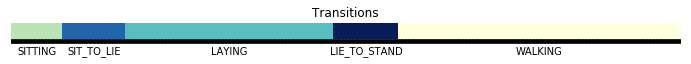

In [18]:
plt.subplots(figsize=(12,0.3))
s=sns.heatmap([raw_data_labels[5000:7500,-1]], annot_kws={"size": 20}, cmap="YlGnBu", fmt='d', xticklabels=plot_labels,  yticklabels=[], cbar=False)
title="Transitions"
s.set_title(title)
s.get_figure().savefig("transitions.png", dpi=1200, bbox_inches= "tight")

In [15]:
len(raw_data_labels)

13926

In [167]:
sampling_rate, window_size = 50, 1
window_size = int(sampling_rate * window_size)
preds = []
cusum_acc_x = []
for idx in range(len(raw_data_labels)):
    s = None
    start_idx = max(0, idx - window_size)
    window = raw_data_labels[start_idx:idx+1, :-1]
    avg = 0.
    std = 0.
    avg = np.mean(window, axis=0)
    std = np.std(window, axis=0)
    for val in window:
        if(s is None):
            s = val
            #avg = s
        else:
            s = s+val

        s_t = (s-avg-2*std)
        s_t = np.amax(np.vstack((np.zeros_like(s_t), s_t)), axis=0)
        s = s_t
    cusum_acc_x.append(s)
cusum_acc_x = np.array(cusum_acc_x)     

In [154]:
sampling_rate, window_size = 50, 1
window_size = int(sampling_rate * window_size)
preds = []
cusum_reverse = []
raw_data_flipped = np.flip(raw_data_labels)
for idx in range(len(raw_data_flipped)):
    s = None
    start_idx = max(0, idx - window_size)
    window = raw_data_flipped[start_idx:idx+1, :-1]
    avg = 0.
    std = 0.
    avg = np.mean(window, axis=0)
    std = np.std(window, axis=0)
    for val in window:
        if(s is None):
            s = val
            #avg = s
        else:
            s = s+val

        s_t = (s-avg-2*std)
        s_t = np.amax(np.vstack((np.zeros_like(s_t), s_t)), axis=0)
        s = s_t
    cusum_reverse.append(s)
cusum_reverse = np.flip(np.array(cusum_reverse))


In [203]:
raw_data_labels.shape

(13926, 7)

In [202]:
cusum_reverse.shape

(13926, 6)

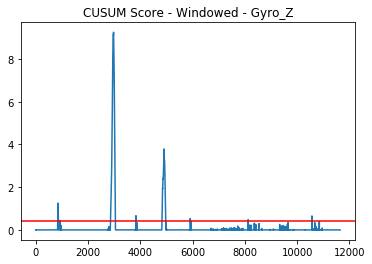

In [183]:
plt.title("CUSUM Score - Windowed - Gyro_Z")
plt.plot(cusum_acc_x[:,2])
plt.axhline(y=0.43, color='r', linestyle='-')

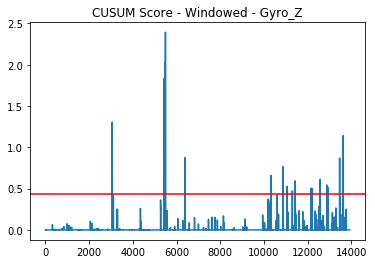

In [184]:
plt.title("CUSUM Score - Windowed - Gyro_Z")
plt.plot(cusum_reverse[:,2])                           
plt.axhline(y=0.43, color='r', linestyle='-')

In [185]:
normalized_cusum = []
min_cusum = min(cusum_acc_x[:,4])
max_cusum = max(cusum_acc_x[:,4])
for c in cusum_acc_x[:,4]:
    normalized_cusum.append((c-min_cusum)/(max_cusum - min_cusum))

In [189]:
min_c = np.min(cusum_acc_x, axis=0)
max_c = np.max(cusum_acc_x, axis=0)

normalized_cusum = []
for c in cusum_acc_x:
    normalized_cusum.append((c-min_c)/(max_c-min_c))
normalized_cusum = np.array(normalized_cusum)

In [186]:
min_c = np.min(cusum_reverse, axis=0)
max_c = np.max(cusum_reverse, axis=0)

normalized_cusum_reverse = []
for c in cusum_reverse:
    normalized_cusum_reverse.append((c-min_c)/(max_c-min_c))
normalized_cusum_reverse = np.array(normalized_cusum_reverse)

In [171]:
sensor_weights = np.array([[0.1,0.1,0.1,0.3,0.8,0.9]])
final_cusum = []
for c in normalized_cusum:
    final_cusum.append(np.sum(c*sensor_weights))

In [164]:
sensor_weights = np.array([[0.1,0.1,0.1,0.3,0.8,0.9]])
final_cusum_reverse = []
for c in normalized_cusum_reverse:
    final_cusum_reverse.append(np.sum(c*sensor_weights))

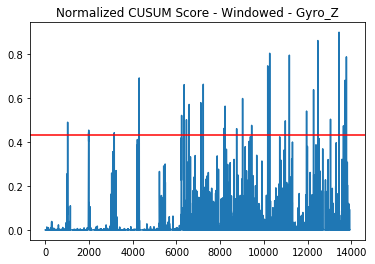

In [172]:
plt.title("Normalized CUSUM Score - Windowed - Gyro_Z")
plt.plot(final_cusum)
plt.axhline(y=0.43, color='r', linestyle='-')

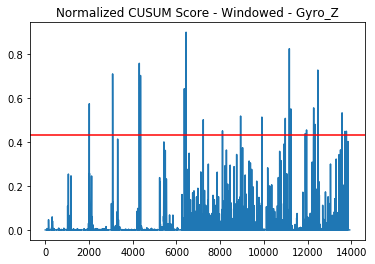

In [165]:
plt.title("Normalized CUSUM Score - Windowed - Gyro_Z")
plt.plot(final_cusum_reverse)
plt.axhline(y=0.43, color='r', linestyle='-')

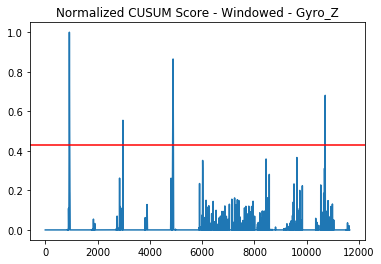

In [196]:
plt.title("Normalized CUSUM Score - Windowed - Gyro_Z")
plt.plot(normalized_cusum[:,4])
plt.axhline(y=0.43, color='r', linestyle='-')

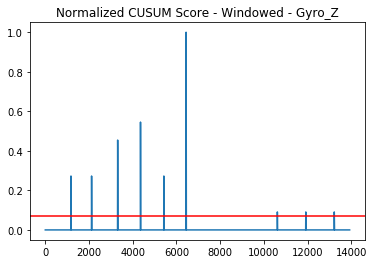

In [199]:
plt.title("Normalized CUSUM Score - Windowed - Gyro_Z")
plt.plot(normalized_cusum_reverse[:,5])
plt.axhline(y=0.07, color='r', linestyle='-')

In [228]:
transition_act=np.where(cusum_score>0.4, True, False)
print(transition_act)
groups = [(list(v), g) for g,v in itertools.groupby(transition_act)]
processed=0
transition_y_hat=[]
#print(groups)
for group in groups:
    cont=group[0]
    g=group[1] 
    trans_pred=0
    if g:
        if(len(cont)>0):
            
            processed+=len(cont)
        else:
            processed+=len(cont)
    else:
        processed+=len(cont)
    transition_y_hat.append(np.ones_like(cont)*trans_pred)

[ True False False ... False False False]


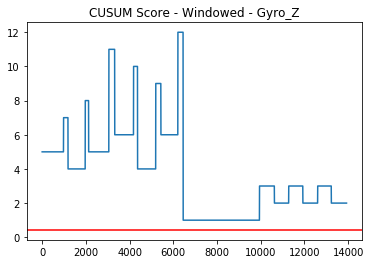

In [187]:
plt.title("CUSUM Score - Windowed - Gyro_Z")
plt.plot(raw_data_labels[:,-1])
plt.axhline(y=0.43, color='r', linestyle='-')

In [43]:
import h5py

In [45]:
f = h5py.File("/home/kavin/Silo/storage/Datasets/WASH_User_study/data/4th_dEEPSENSE_MAY_RAWDATASET_LABELED_107_USERS_windowed_w_1_s_0.0.h5", 'r')


In [58]:
for key in f.keys():
    print(key)
    
group = f[key]

#Checkout what keys are inside that group.
for key in group.keys():
    print(key)

group
data
deepsense_values
featurized
labels
user_id


In [60]:
data = group["data"].value

/home/kavin/virtualenvs/pytorch/local/lib/python2.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [64]:
data.shape

(219946, 18, 50)

In [65]:
deepsense = group["deepsense_values"].value

/home/kavin/virtualenvs/pytorch/local/lib/python2.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [66]:
deepsense.shape

(219946, 20, 240)

In [67]:
labels = group["labels"].value

/home/kavin/virtualenvs/pytorch/local/lib/python2.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [68]:
labels.shape

(219946, 25)

In [69]:
uid = group["user_id"].value

/home/kavin/virtualenvs/pytorch/local/lib/python2.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [98]:
uid

array(['UUID_0038', 'UUID_0038', 'UUID_0038', ..., 'UUID_0037',
       'UUID_0037', 'UUID_0037'], dtype='|S50')

In [92]:
np.repeat(np.arange(10).reshape(2,5),3, axis=0)

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9],
       [5, 6, 7, 8, 9],
       [5, 6, 7, 8, 9]])

In [73]:
x = np.arange(30).reshape(2, 5, 3)
x

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14]],

       [[15, 16, 17],
        [18, 19, 20],
        [21, 22, 23],
        [24, 25, 26],
        [27, 28, 29]]])

In [84]:
np.vstack(x.transpose( 0,2, 1))

array([[ 0,  3,  6,  9, 12],
       [ 1,  4,  7, 10, 13],
       [ 2,  5,  8, 11, 14],
       [15, 18, 21, 24, 27],
       [16, 19, 22, 25, 28],
       [17, 20, 23, 26, 29]])

In [93]:
raw_data = np.vstack(data.transpose(0,2,1))

In [95]:
raw_uid = np.repeat(uid, 50)
raw_labels = np.repeat(labels, 50, axis=0)

In [96]:
np.unique(raw_uid)

array(['UUID_0037', 'UUID_0038', 'UUID_0039', 'UUID_0040', 'UUID_0041',
       'UUID_0042', 'UUID_0042_1', 'UUID_0043', 'UUID_0044', 'UUID_0045',
       'UUID_0046', 'UUID_0047', 'UUID_0048', 'UUID_0049', 'UUID_0050',
       'UUID_0051', 'UUID_0052', 'UUID_0053', 'UUID_0054', 'UUID_0055',
       'UUID_0056', 'UUID_0057', 'UUID_0058', 'UUID_0059', 'UUID_0060',
       'UUID_0061', 'UUID_0062', 'UUID_0063', 'UUID_0064', 'UUID_0065',
       'UUID_0066', 'UUID_0067', 'UUID_0068', 'UUID_0069', 'UUID_0070',
       'UUID_0071', 'UUID_0072', 'UUID_0073', 'UUID_0074', 'UUID_0075',
       'UUID_0076', 'UUID_0077', 'UUID_0078', 'UUID_0079', 'UUID_0080',
       'UUID_0083', 'UUID_0084', 'UUID_0085', 'UUID_0086', 'UUID_0087',
       'UUID_0088', 'UUID_0089', 'UUID_0090', 'UUID_0091', 'UUID_0092',
       'UUID_0093', 'UUID_0094', 'UUID_0095', 'UUID_0096', 'UUID_0097',
       'UUID_0098', 'UUID_0099', 'UUID_0100', 'UUID_0101', 'UUID_0102',
       'UUID_0103', 'UUID_0104', 'UUID_0105', 'UUID_0106', 'UU

In [103]:
raw_data[np.where(raw_uid == "UUID_0038"),:][0]

(95650, 18)

In [29]:
np.linspace(0., 1., 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [30]:
weights = np.array(np.meshgrid(np.linspace(0., 1., 11), np.linspace(0., 1., 11), np.linspace(0., 1., 11), np.linspace(0., 1., 11), np.linspace(0., 1., 11), np.linspace(0., 1., 11))).T.reshape(-1,6)
weights.shape

(1771561, 6)

In [31]:
weights[:20]

array([[0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. , 0. ],
       [0. , 0.2, 0. , 0. , 0. , 0. ],
       [0. , 0.3, 0. , 0. , 0. , 0. ],
       [0. , 0.4, 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0. , 0. , 0. ],
       [0. , 0.6, 0. , 0. , 0. , 0. ],
       [0. , 0.7, 0. , 0. , 0. , 0. ],
       [0. , 0.8, 0. , 0. , 0. , 0. ],
       [0. , 0.9, 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. , 0. ],
       [0.1, 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0.1, 0. , 0. , 0. , 0. ],
       [0.1, 0.2, 0. , 0. , 0. , 0. ],
       [0.1, 0.3, 0. , 0. , 0. , 0. ],
       [0.1, 0.4, 0. , 0. , 0. , 0. ],
       [0.1, 0.5, 0. , 0. , 0. , 0. ],
       [0.1, 0.6, 0. , 0. , 0. , 0. ],
       [0.1, 0.7, 0. , 0. , 0. , 0. ],
       [0.1, 0.8, 0. , 0. , 0. , 0. ]])

In [35]:
window_lens = [5, 10, 15]
buffer_list = [2, 5, 10]
threshold = np.linspace(0.1, 0.9, 9)
reverse = [True, False]
hyperparameters = [window_lens, buffer_list, threshold, reverse]
all_parameter_combinations=list(itertools.product(*hyperparameters))


In [36]:
len(all_parameter_combinations)

216